In [62]:
#by Willkie
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression

import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
#https://discord.com/channels/1134059900666916935/1283610000484208670

In [71]:
%run data_loading.ipynb

Data saved as data/output/1219.csv
Processed valid data saved as data/output/1219_processed.csv
Data saved as data/output/1218.csv
Processed valid data saved as data/output/1218_processed.csv
Data saved as data/output/1220.csv
Processed valid data saved as data/output/1220_processed.csv
Data saved as data/output/1221.csv
Processed valid data saved as data/output/1221_processed.csv
Data saved as data/output/1213.csv
Processed valid data saved as data/output/1213_processed.csv
Data saved as data/output/1212.csv
Processed valid data saved as data/output/1212_processed.csv
Data saved as data/output/1211.csv
Processed valid data saved as data/output/1211_processed.csv
Data saved as data/output/1215.csv
Processed valid data saved as data/output/1215_processed.csv
Data saved as data/output/1214.csv
Processed valid data saved as data/output/1214_processed.csv
Data saved as data/output/1216.csv
Processed valid data saved as data/output/1216_processed.csv
Data saved as data/output/1217.csv
Proce

In [72]:
df

,party_id,time,level,job,spec,map,date,valid,valid_spec,spec_by_level,avg_spec_by_level,spec_filled,spec_distance,avg_distance_per_job,tsne_dim1,tsne_dim2,distance_to_nearest
0,1,오전 12:33,88.0,허밋,None,붉켄,2024-12-19,True,False,18.446821,18.446821,1619.782343,NaN,2415.678179,-13.249030,-10.406365,0.351018
1,1,오전 12:33,101.0,레인저,None,붉켄,2024-12-19,True,False,22.312474,22.312474,2305.155949,NaN,2402.687526,-18.843714,-33.427643,0.004064
2,2,오전 12:33,90.0,허밋,None,붉켄,2024-12-19,True,False,18.446821,18.446821,1687.355922,NaN,2415.678179,-12.918878,-9.519718,0.107972
3,2,오전 12:33,99.0,허밋,None,붉켄,2024-12-19,True,False,18.446821,18.446821,1800.394389,NaN,2415.678179,-12.016580,-6.087815,0.194776
4,2,오전 12:33,105.0,썬콜,650,붉켄,2024-12-19,True,True,6.190476,6.212019,650.000000,643.787981,793.121314,-18.378849,48.684963,0.001658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536,292,오후 1:59,143.0,용기사,5000,블와둥,2024-12-17,True,True,34.965035,35.282984,5000.000000,4964.717016,4940.217016,57.379452,-15.928256,0.099545
3537,297,오후 1:59,119.0,프리스트,None,검켄,2024-12-17,True,False,6.320755,6.320755,730.129423,NaN,663.679245,-63.594398,4.726683,0.001489
3538,297,오후 1:59,134.0,프리스트,None,검켄,2024-12-17,True,False,6.320755,6.320755,841.963953,NaN,663.679245,-59.433933,8.899166,0.010652
3539,300,오후 1:59,123.0,프리스트,None,None,2024-12-17,False,False,6.320755,6.320755,793.420817,NaN,663.679245,-28.770735,6.268525,0.012266


In [73]:
processed_df

,party_id,time,level,job,spec,map,date,valid,valid_spec,spec_by_level,avg_spec_by_level,spec_filled,spec_distance,avg_distance_per_job,tsne_dim1,tsne_dim2,distance_to_nearest
0,2,오전 12:33,105.0,썬콜,650,붉켄,2024-12-19,True,True,6.190476,6.212019,650.0,643.787981,793.121314,-21.927694,13.199575,0.173588
1,2,오전 12:33,118.0,썬콜,726,붉켄,2024-12-19,True,True,6.152542,6.212019,726.0,719.787981,793.121314,-22.330854,13.415393,0.284696
2,13,오전 12:34,128.0,불독,795,협동,2024-12-19,True,True,6.210938,6.210938,795.0,788.789062,788.789062,-19.725958,18.329945,0.148244
3,18,오전 12:34,124.0,용기사,4200,블와둥,2024-12-19,True,True,33.870968,34.726694,4200.0,4165.273306,4411.364215,27.569923,-16.980835,0.206580
4,34,오전 12:35,144.0,허밋,2652,망용둥,2024-12-19,True,True,18.416667,18.446821,2652.0,2633.553179,2415.678179,-2.952811,13.475213,0.462273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,260,오후 1:57,106.0,나이트,3143,듀파,2024-12-17,True,True,29.650943,30.555809,3143.0,3112.444191,2940.944191,7.431334,-15.151710,0.164715
396,260,오후 1:57,89.0,나이트,2800,듀파,2024-12-17,True,True,31.460674,30.555809,2800.0,2769.444191,2940.944191,7.351911,-15.387248,0.083902
397,263,오후 1:57,106.0,프리스트,670,불어전,2024-12-17,True,True,6.320755,6.320755,670.0,663.679245,663.679245,-28.984577,10.065437,0.195862
398,263,오후 1:57,107.0,용기사,3400,불어전,2024-12-17,True,True,31.775701,35.282984,3400.0,3364.717016,4940.217016,28.860945,-11.660034,1.141177


In [74]:
hermit = processed_df[(processed_df['job'] == '허밋')]
hermit

,party_id,time,level,job,spec,map,date,valid,valid_spec,spec_by_level,avg_spec_by_level,spec_filled,spec_distance,avg_distance_per_job,tsne_dim1,tsne_dim2,distance_to_nearest
4,34,오전 12:35,144.0,허밋,2652,망용둥,2024-12-19,True,True,18.416667,18.446821,2652.0,2633.553179,2415.678179,-2.952811,13.475213,0.462273
6,51,오전 12:35,138.0,허밋,2540,협동,2024-12-19,True,True,18.405797,18.446821,2540.0,2521.553179,2415.678179,0.513331,7.879973,0.462415
8,55,오전 12:36,99.0,허밋,1840,듀파,2024-12-19,True,True,18.585859,18.446821,1840.0,1821.553179,2415.678179,-8.928614,-0.547560,0.129262
10,56,오전 12:36,153.0,허밋,2982,큰둥,2024-12-19,True,True,19.490196,18.446821,2982.0,2963.553179,2415.678179,1.986549,13.684211,0.039583
17,89,오전 12:37,145.0,허밋,2600,깊바협,2024-12-19,True,True,17.931034,18.446821,2600.0,2581.553179,2415.678179,0.166158,11.808363,0.105665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,161,오후 1:52,140.0,허밋,2700,협동,2024-12-17,True,True,19.285714,18.956725,2700.0,2681.043275,2502.176609,0.965204,8.189490,0.258916
380,161,오후 1:52,133.0,허밋,2400,협동,2024-12-17,True,True,18.045113,18.956725,2400.0,2381.043275,2502.176609,-0.198158,7.594755,0.588010
383,163,오후 1:52,124.0,허밋,2500,협동,2024-12-17,True,True,20.161290,18.956725,2500.0,2481.043275,2502.176609,-0.477614,6.157124,0.066798
386,197,오후 1:54,124.0,허밋,2520,협동,2024-12-17,True,True,20.322581,18.956725,2520.0,2501.043275,2502.176609,-0.420508,6.122471,0.066798


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3532 entries, 0 to 3531
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   party_id              3532 non-null   int64  
 1   time                  3532 non-null   object 
 2   level                 3532 non-null   float64
 3   job                   3532 non-null   object 
 4   spec                  463 non-null    float64
 5   map                   3160 non-null   object 
 6   date                  3532 non-null   object 
 7   valid                 3532 non-null   bool   
 8   valid_spec            3532 non-null   bool   
 9   spec_by_level         3233 non-null   float64
 10  avg_spec_by_level     3233 non-null   float64
 11  spec_filled           3532 non-null   float64
 12  spec_distance         463 non-null    float64
 13  avg_distance_per_job  3233 non-null   float64
 14  tsne_dim1             3532 non-null   float64
 15  tsne_dim2

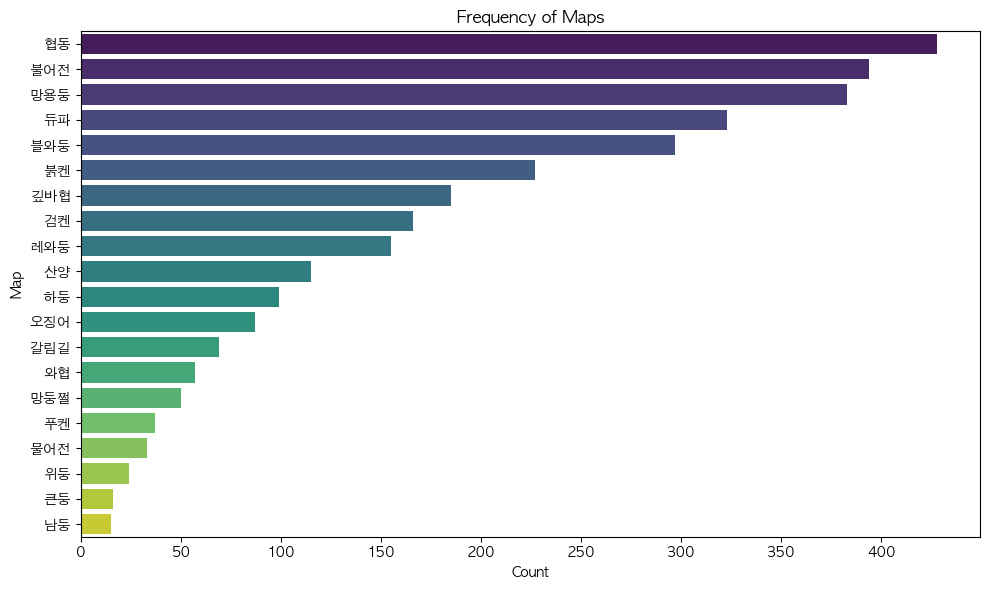

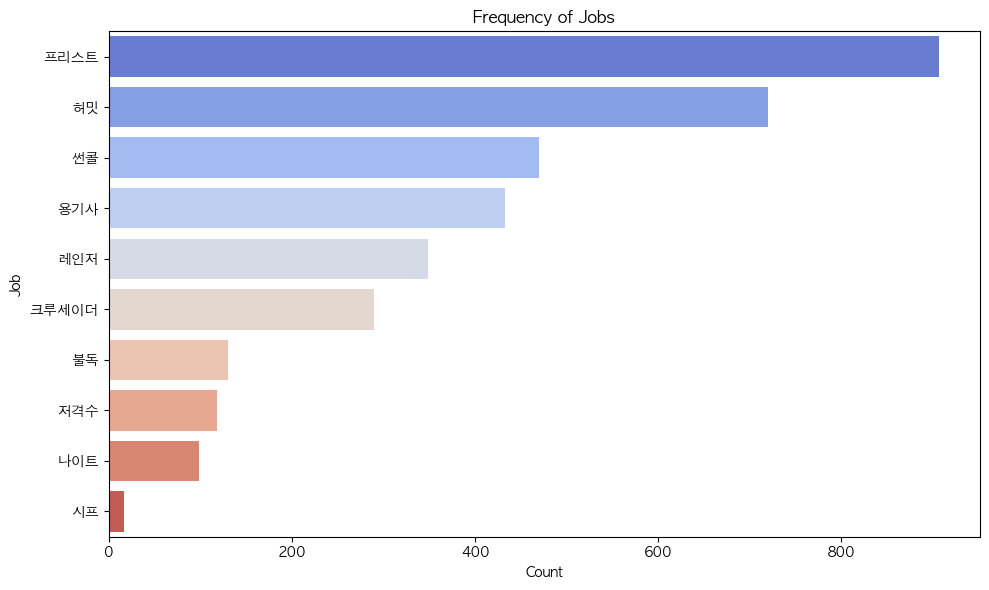

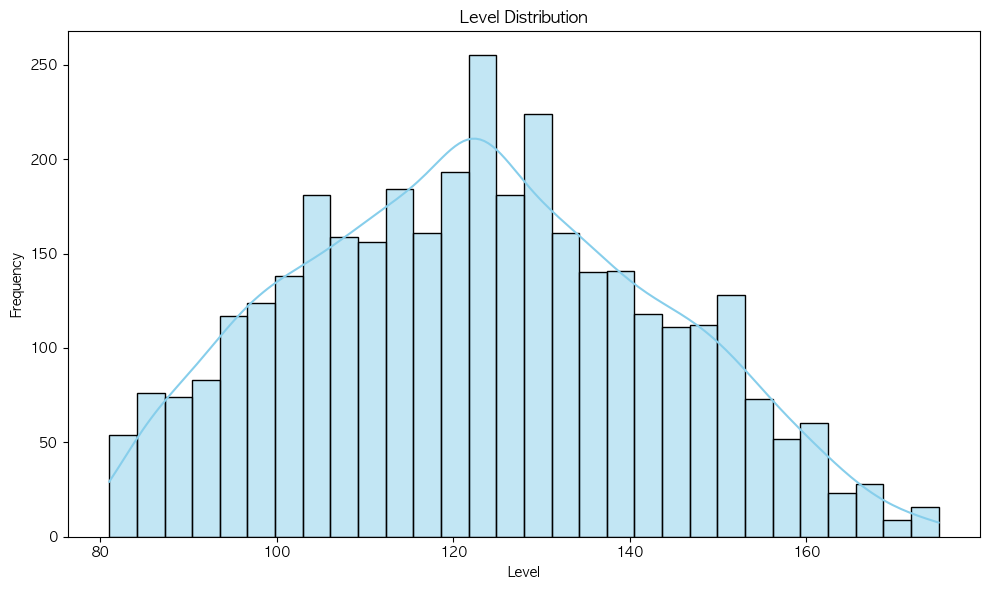

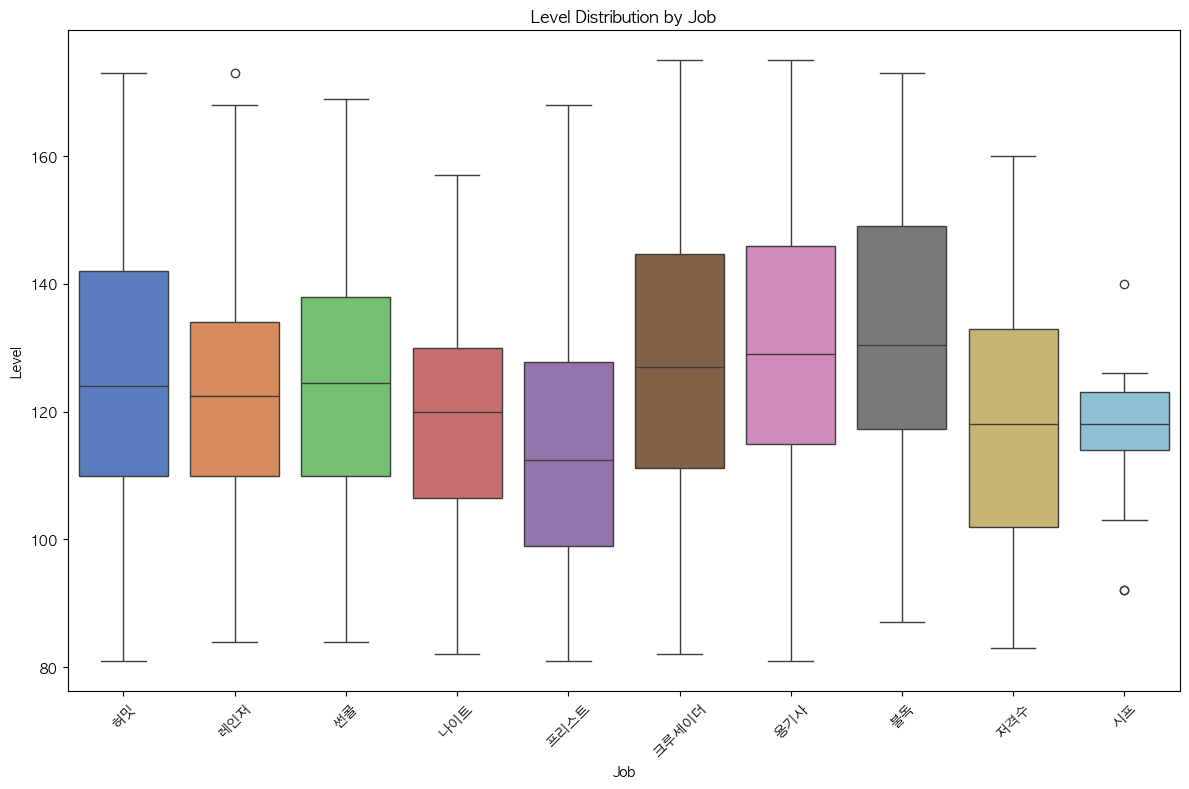

In [75]:
%run eda.ipynb

map_dist(df)
job_dist(df)
level_dist(df)
level_dist_by_job(df)

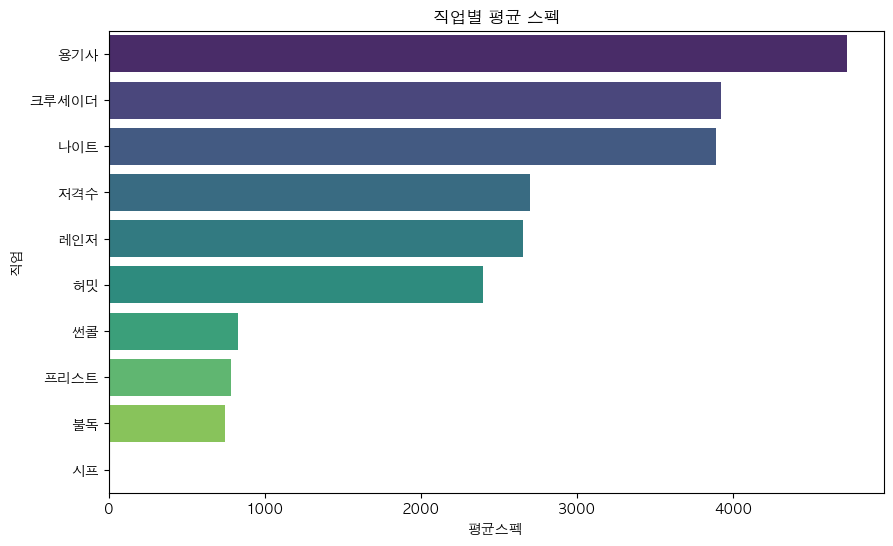

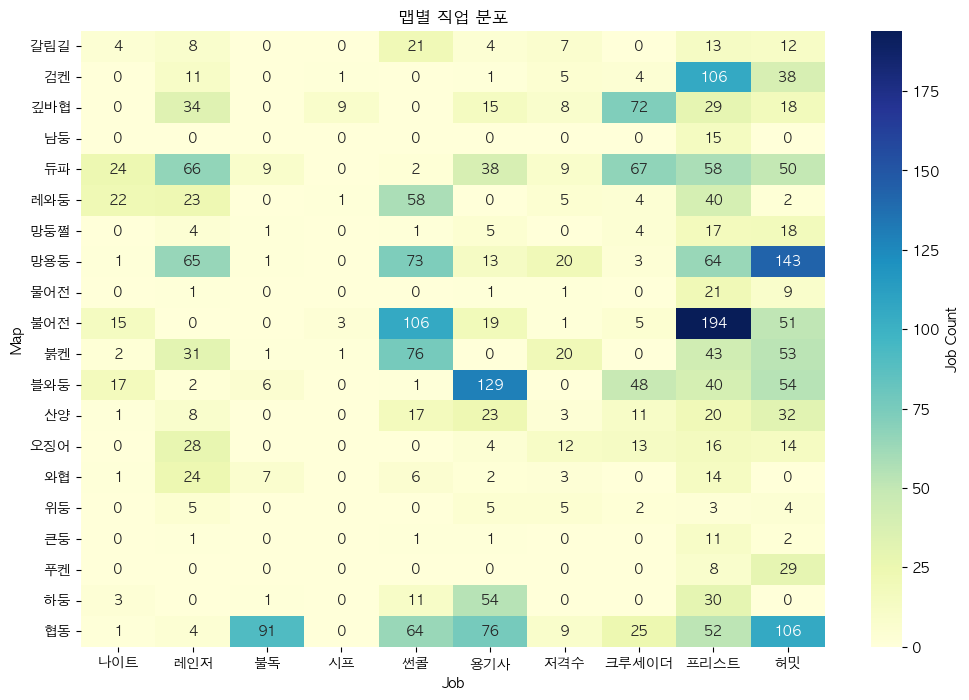

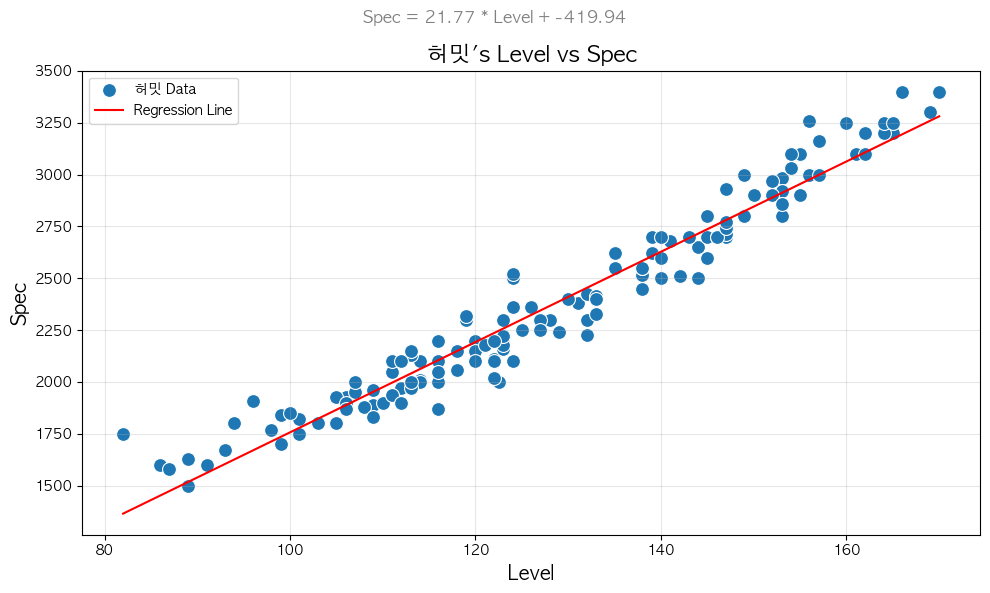

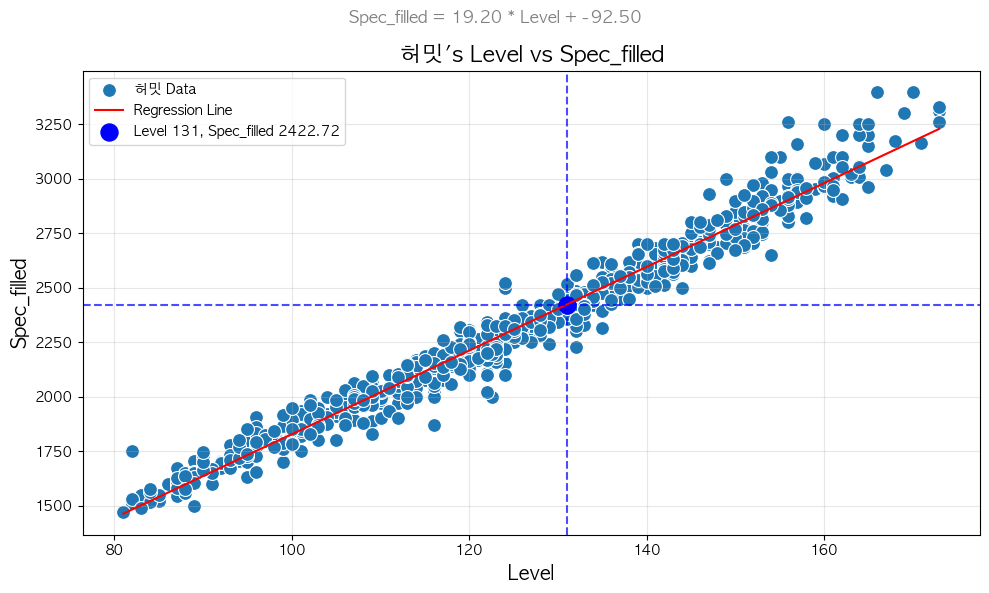

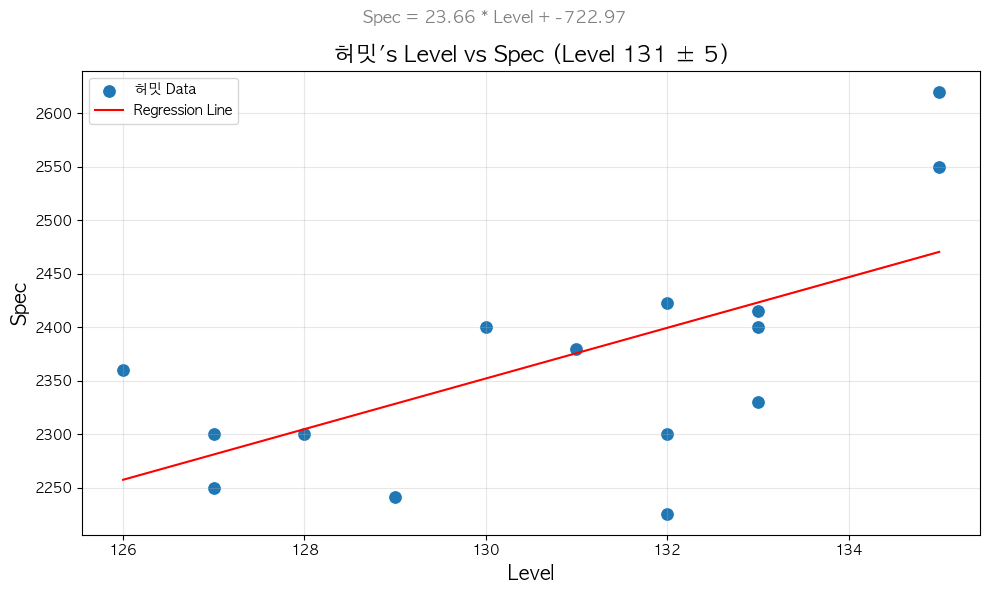

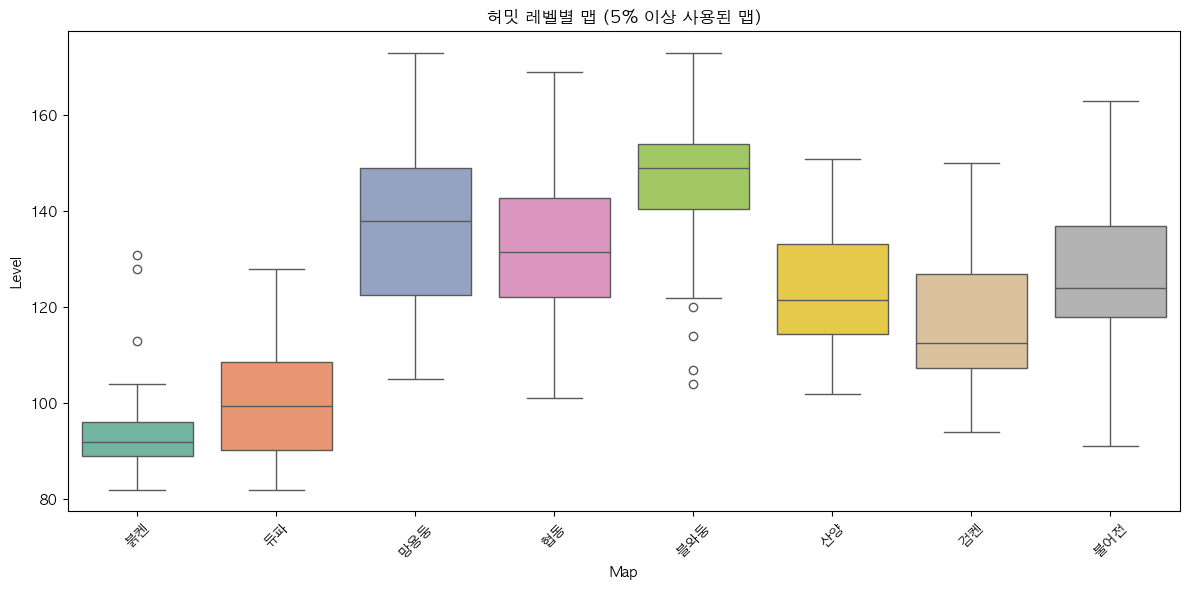

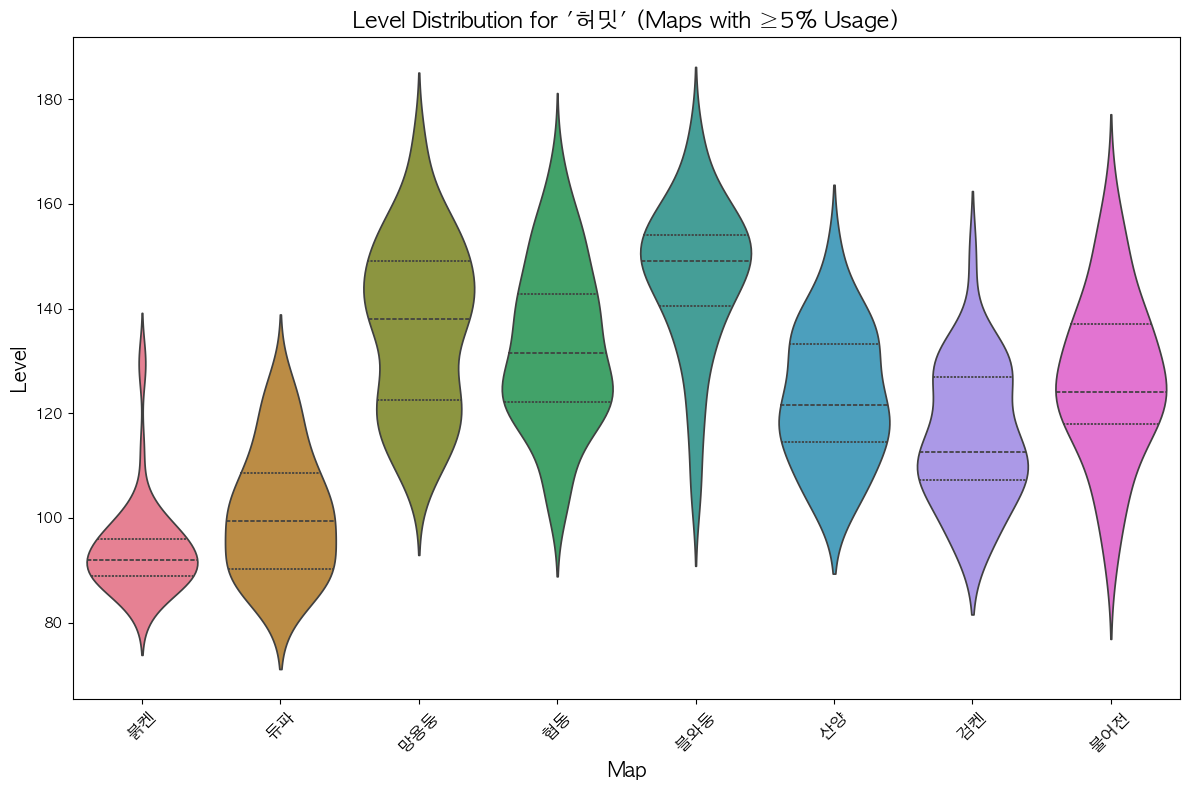

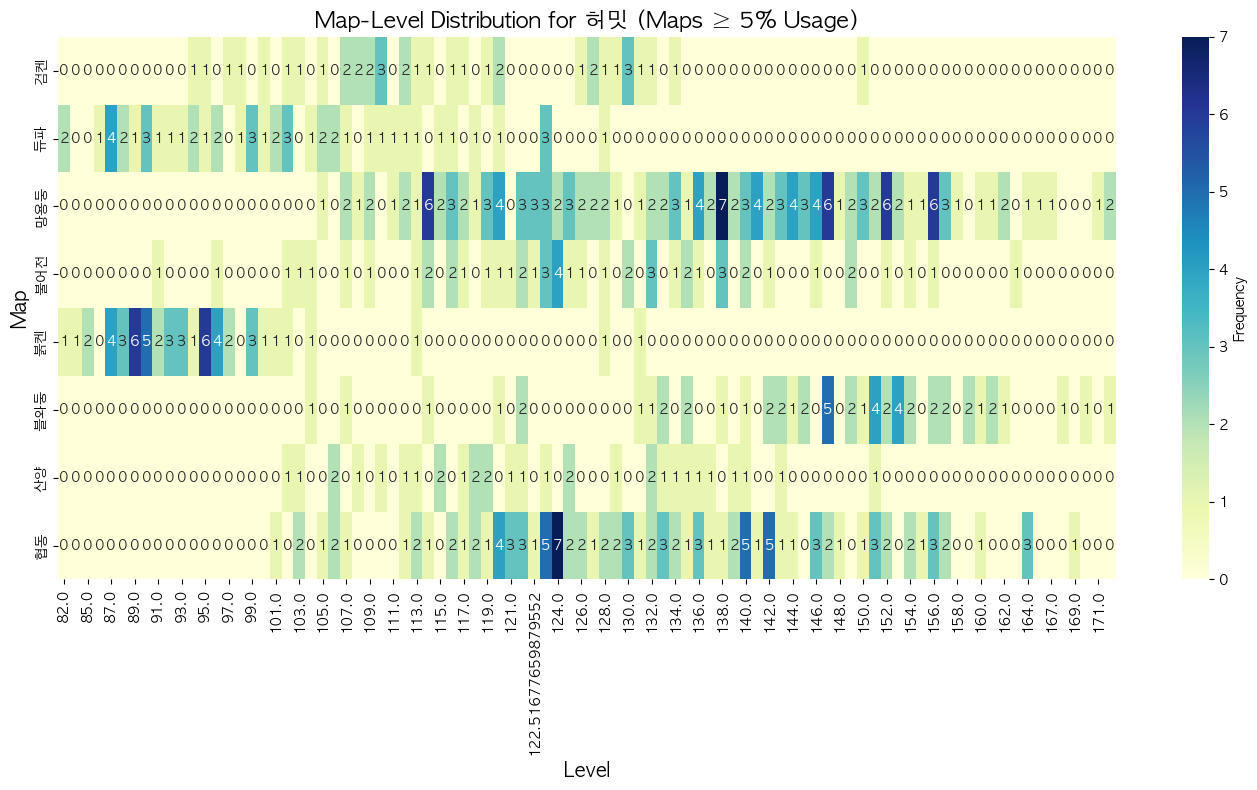

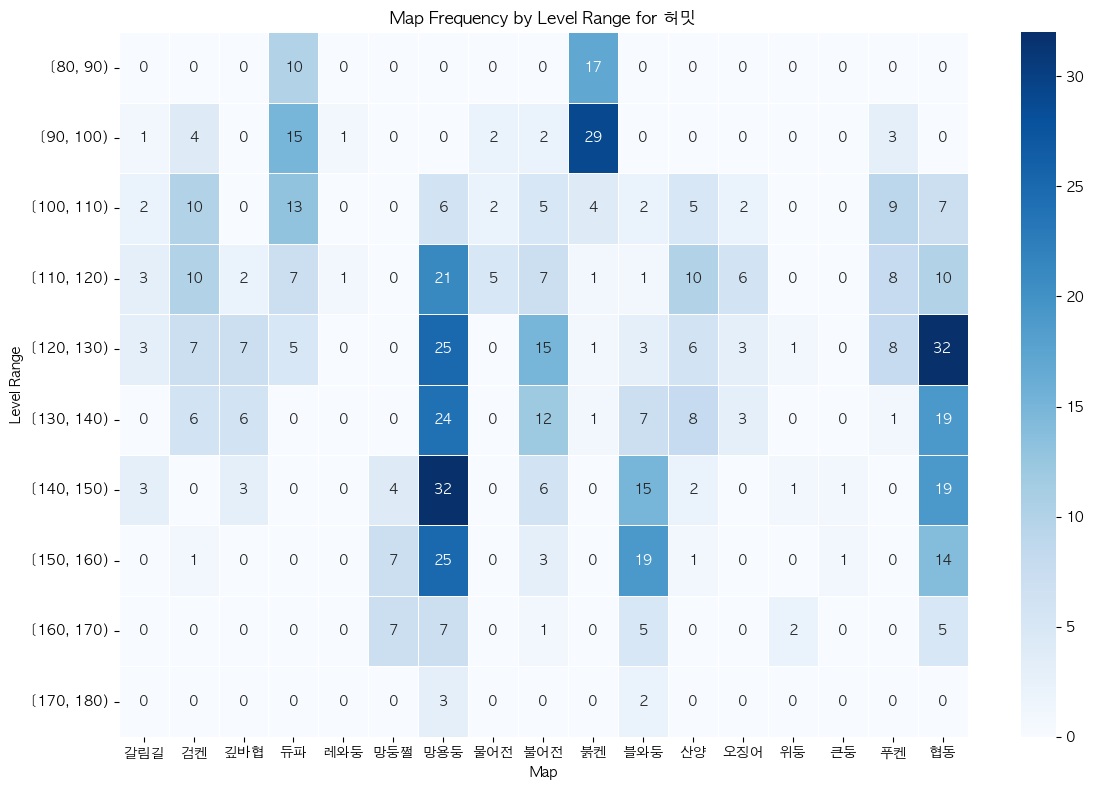

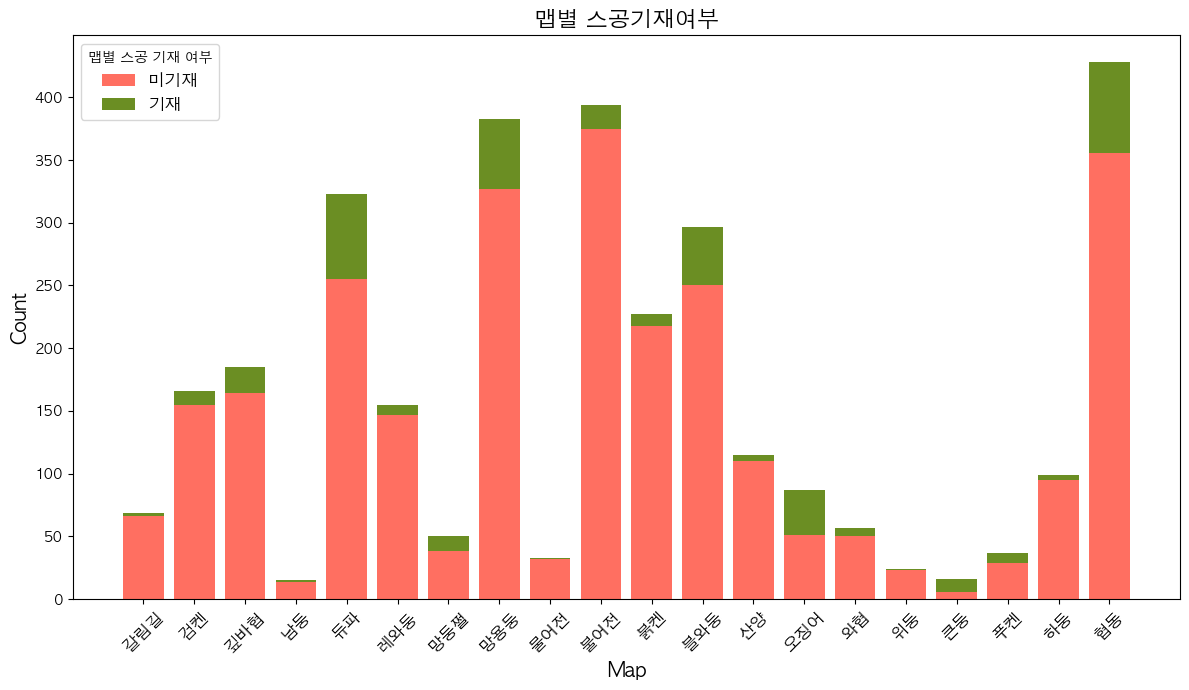

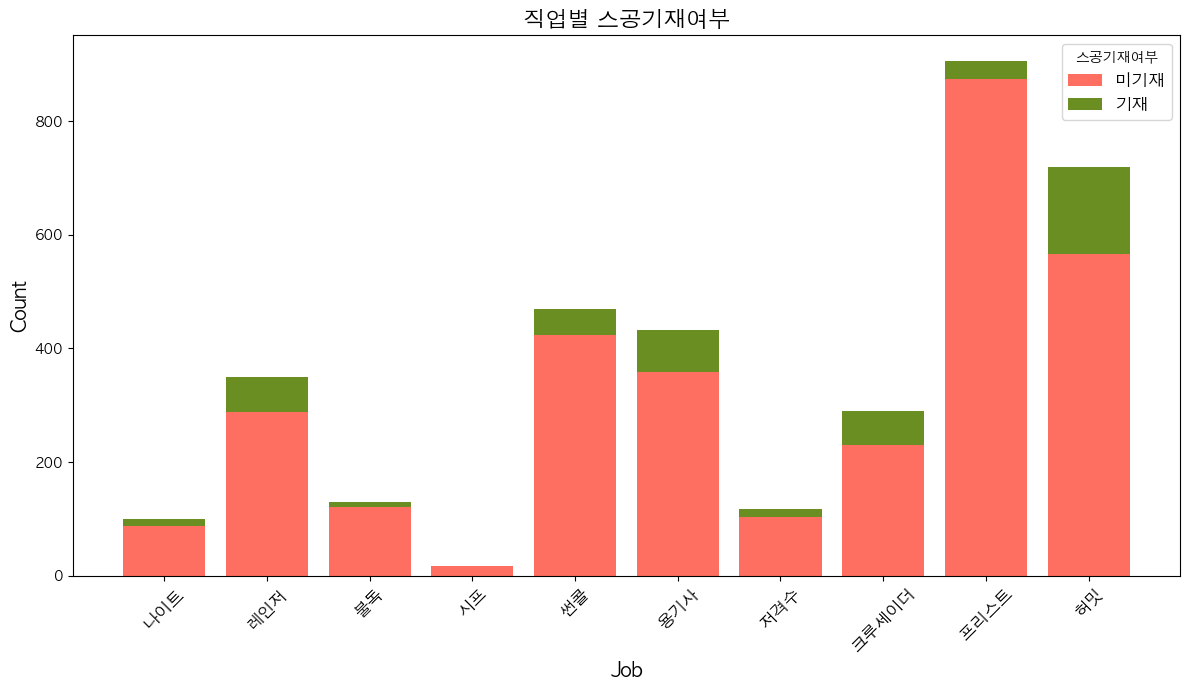

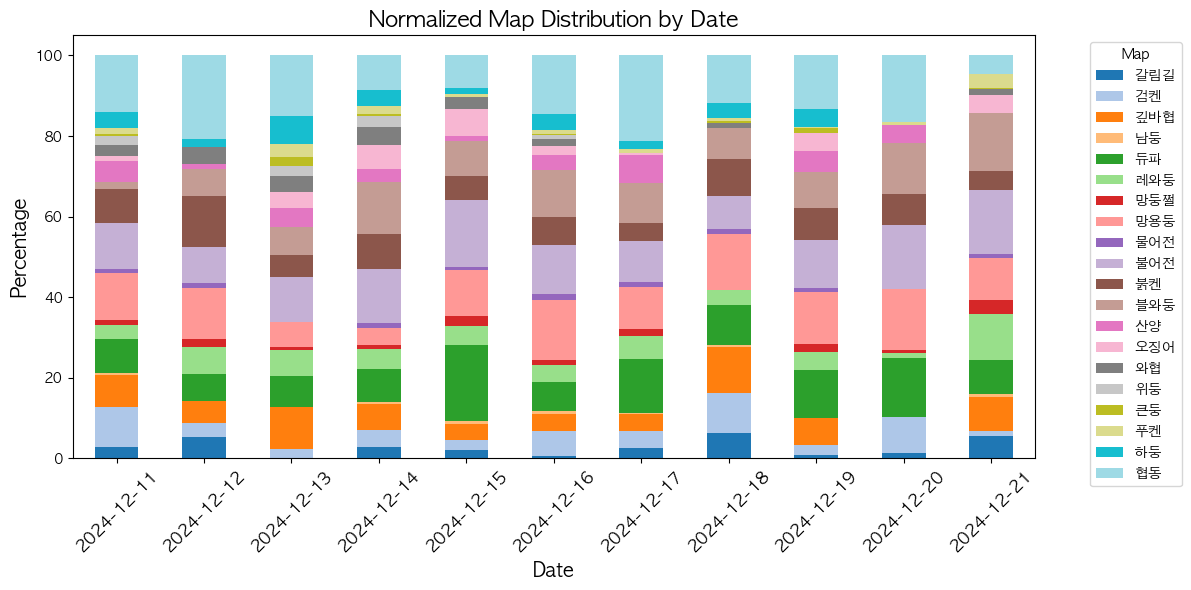

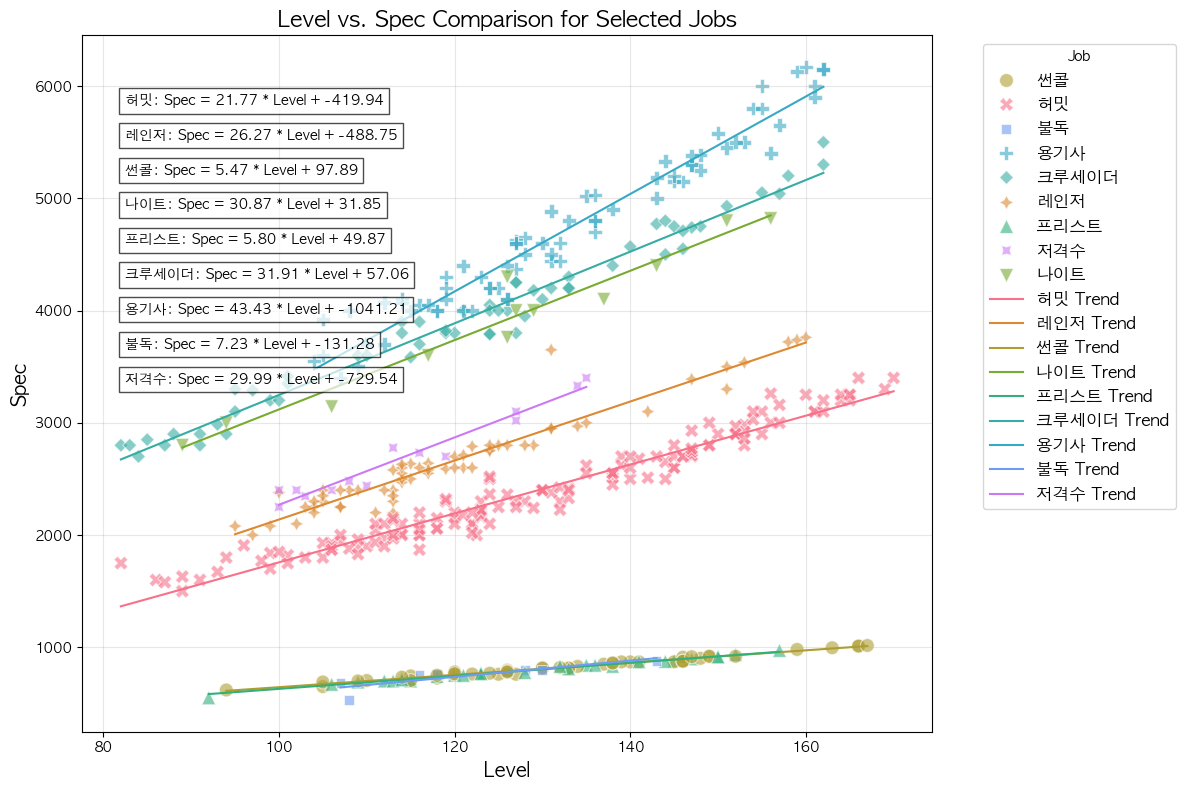

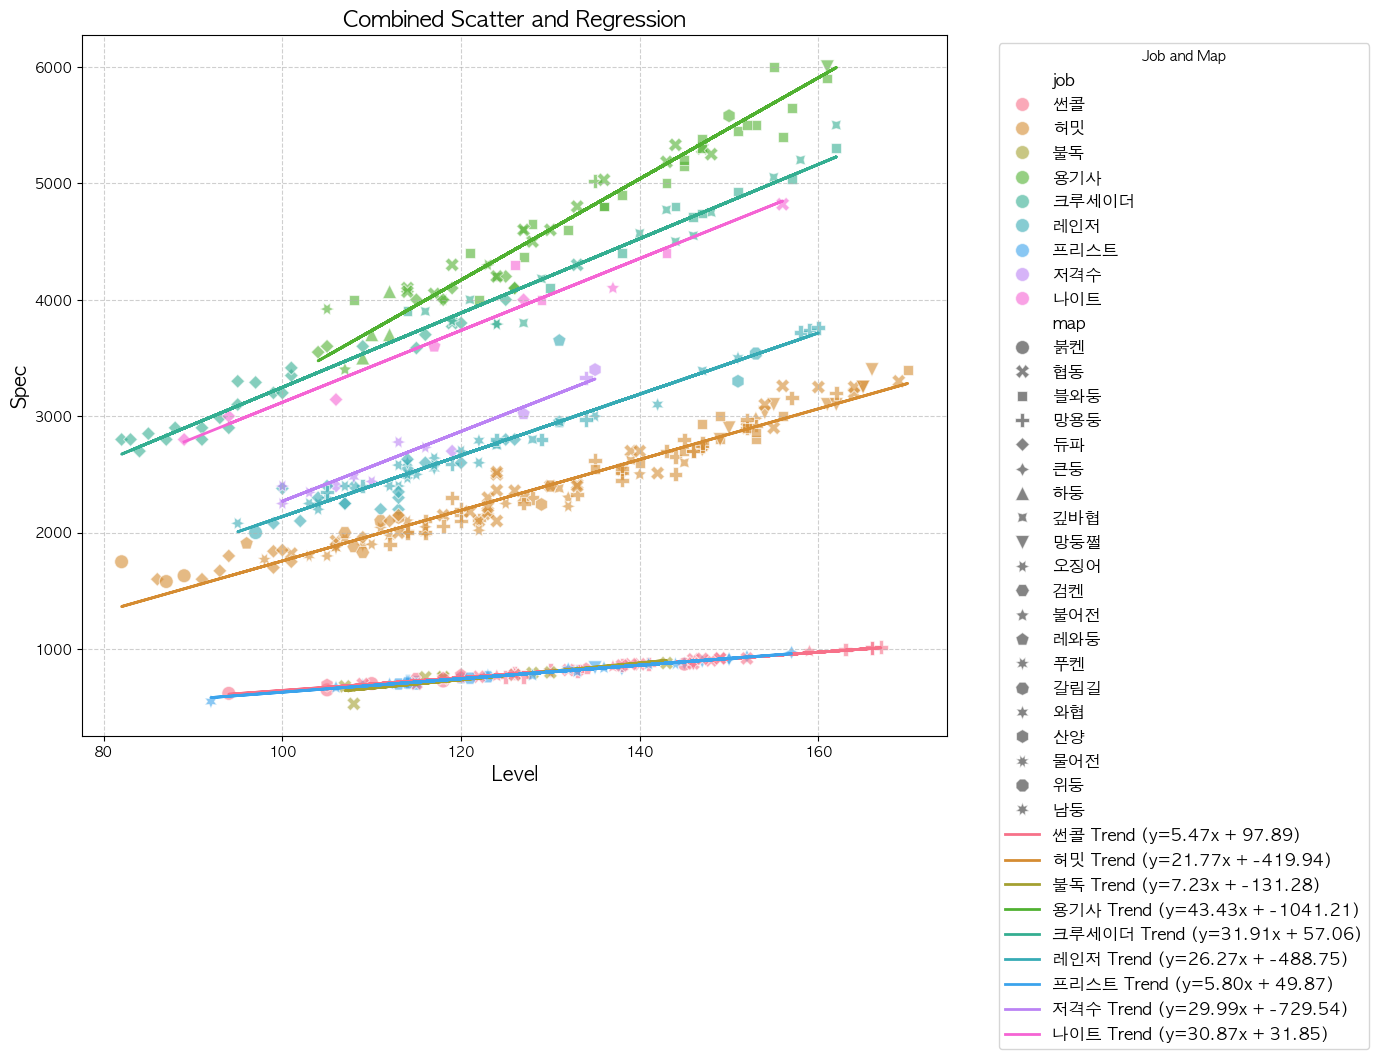

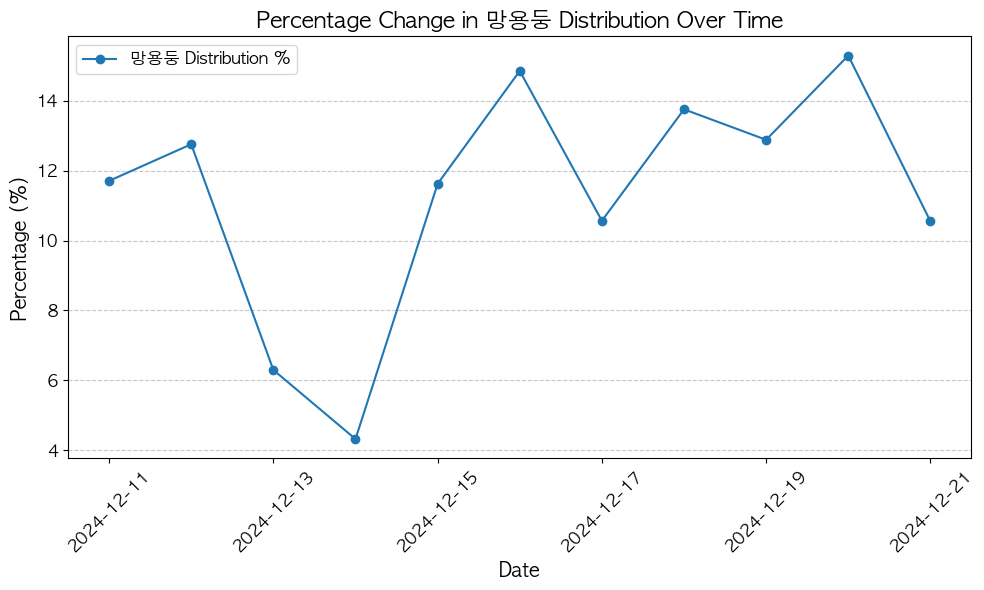

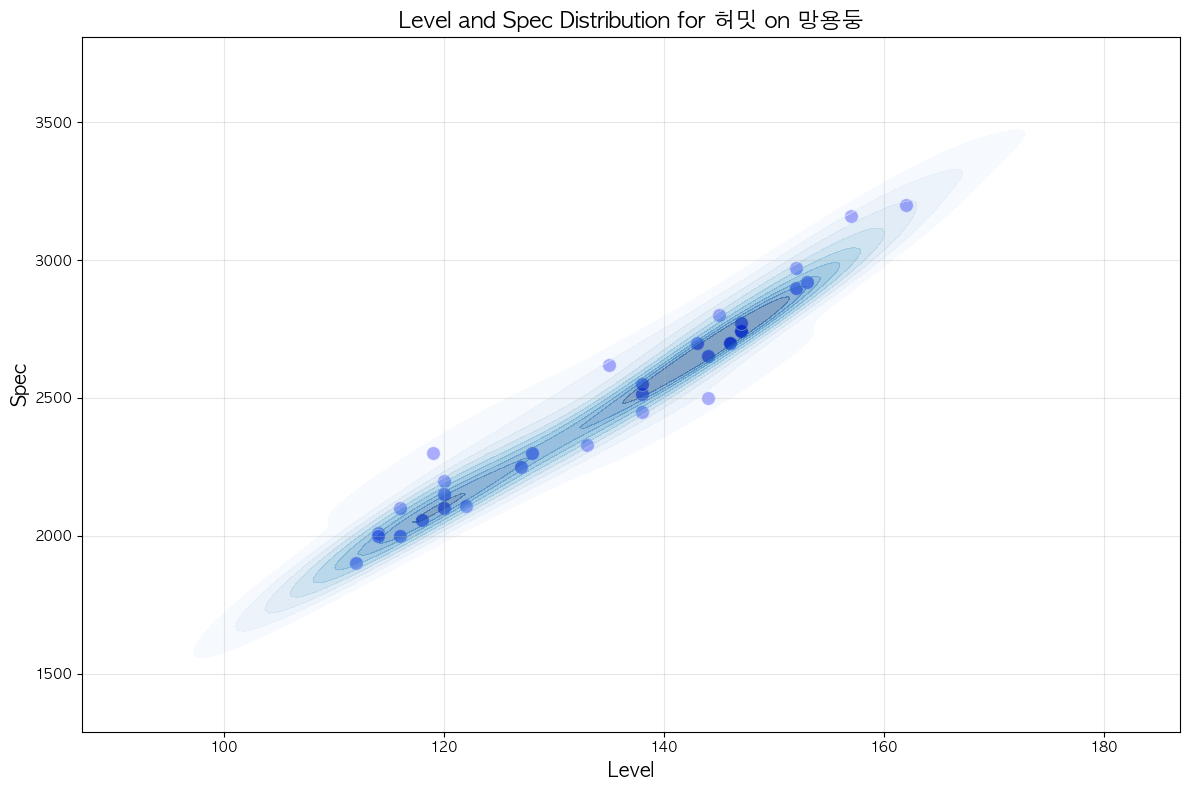

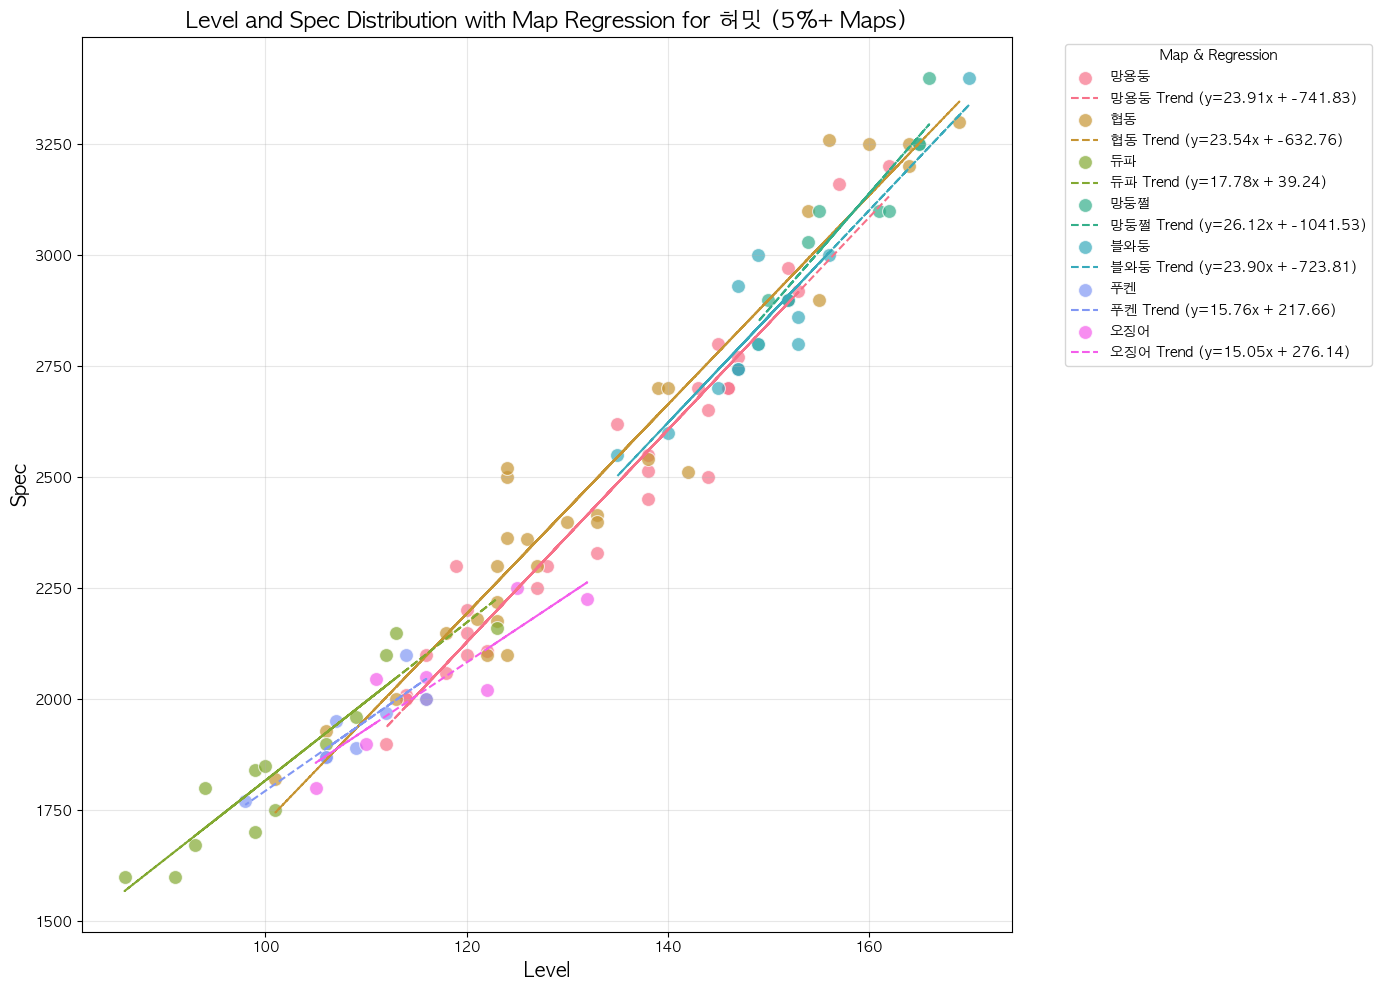

In [76]:
%run data_visualization.ipynb

job="허밋"
jobs=["허밋", "썬콜", "용기사"]
input_map="망용둥"
input_maps=["망용둥", "불어전"]
start_level=120
end_level=160
input_level=131

#1 직업별 평균 스펙
average_spec_by_job(df)
#2 맵별 직업 분포
plot_job_frequency_by_map(df)
#3 특정 직업, 레벨(optional), 스펙_filled
plot_level_spec_with_regression(df, job)
plot_level_spec_with_regression(df, job, input_level=input_level, use_spec_filled=True)
#4 레벨+-5의 스펙 회귀
plot_level_spec_with_regression_by_level(df, job, input_level)
#5 특정 직업의 레벨 별 맵 분포
plot_level_by_map_by_job(df, job)
#6 특정직업의 레벨별 사냥터 분포(5%+)
plot_level_distribution_by_job_and_map(df, job)
#7 특정 직업의 레벨별 맵 히트맵
plot_map_level_heatmap_for_job(df, job)
#8 특정직업의 레벨 범위별 사냥터 히트맵 
plot_map_frequency_by_level_range(df, job)
#9 맵별 스펙 기재 여부
visualize_spec_validity_by_map(df, job='all')
#10 직업별 스펙 기재 여부, job optional
visualize_spec_validity_by_jobs(df, jobs=None)
#11 날짜별 맵 사용 비율
visualize_map_distribution_by_date(df)
#12 직업별 레벨(범위 설정 가능)당 스펙
visualize_level_spec_comparison(df, jobs=None, start_level=None, end_level=None)
#13 직업별 레벨에 따른 스공과 맵, 회귀
plot_combined_scatter_with_regression(df, start_level=None, end_level=None, maps=None)
#14 맵 사용빈도 변화 추이
visualize_map_percentage_change(df, input_map)
#15 특정 직업의 맵 레벨과 스펙에 따른 분포도
plot_level_spec_distribution_of_job_and_map(df, input_map, job, use_spec_filled=False)
#16 특정 직업의 맵별분포와 레벨, 스펙 회귀
plot_level_spec_distribution_of_job(df, job)

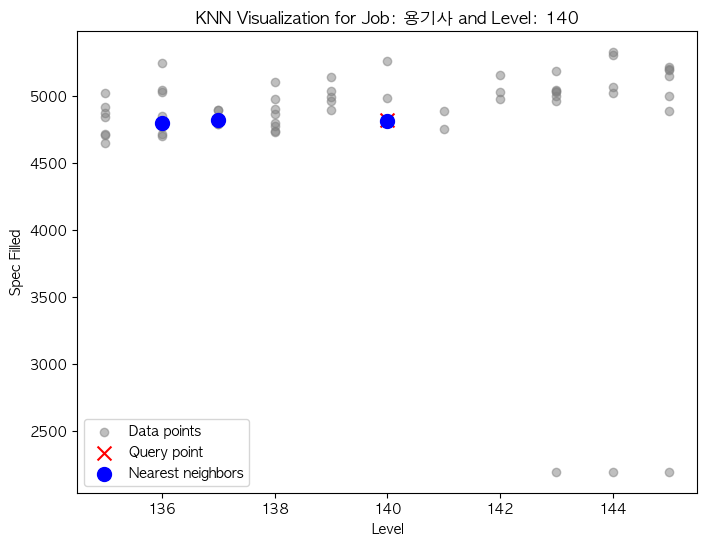

Similarity scores for recommended maps:
Map: 협동, Score: 3.7478198488086742
Map: 위둥, Score: 6.117644821507383
Map: 블와둥, Score: 18.50812141763379
Recommended Maps and Scores: ['협동', '위둥', '블와둥']


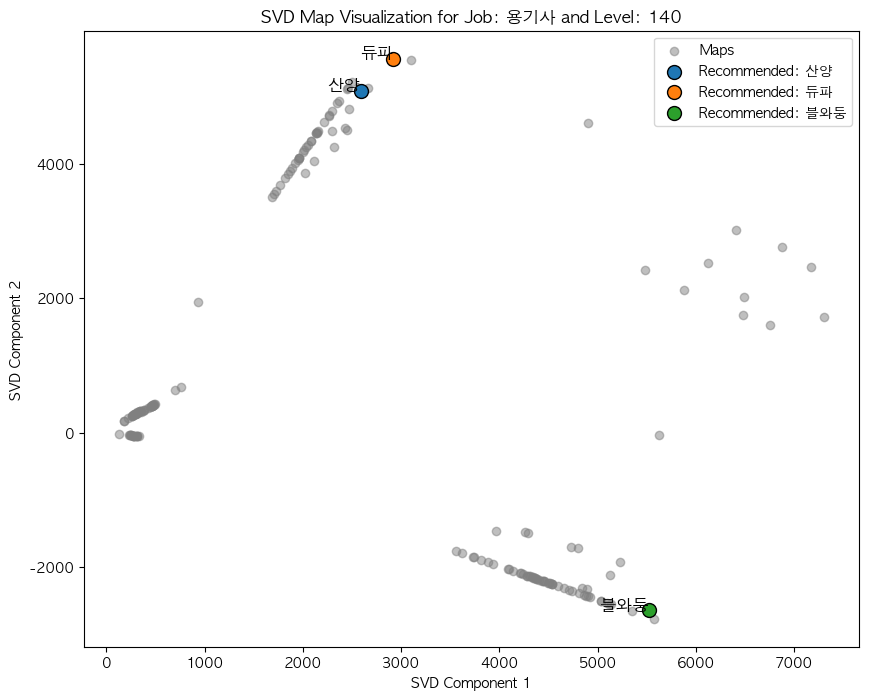

Unique maps after preprocessing:
['하둥' '협동' '블와둥' '산양' '듀파']
Similarity scores for recommended maps:
Map: 블와둥, Score: 0.5000000000000001
Map: 산양, Score: 0.4999999999999998
Map: 듀파, Score: 3.8163916471489756e-17
Recommended Maps: Index(['블와둥', '산양', '듀파'], dtype='object', name='map')


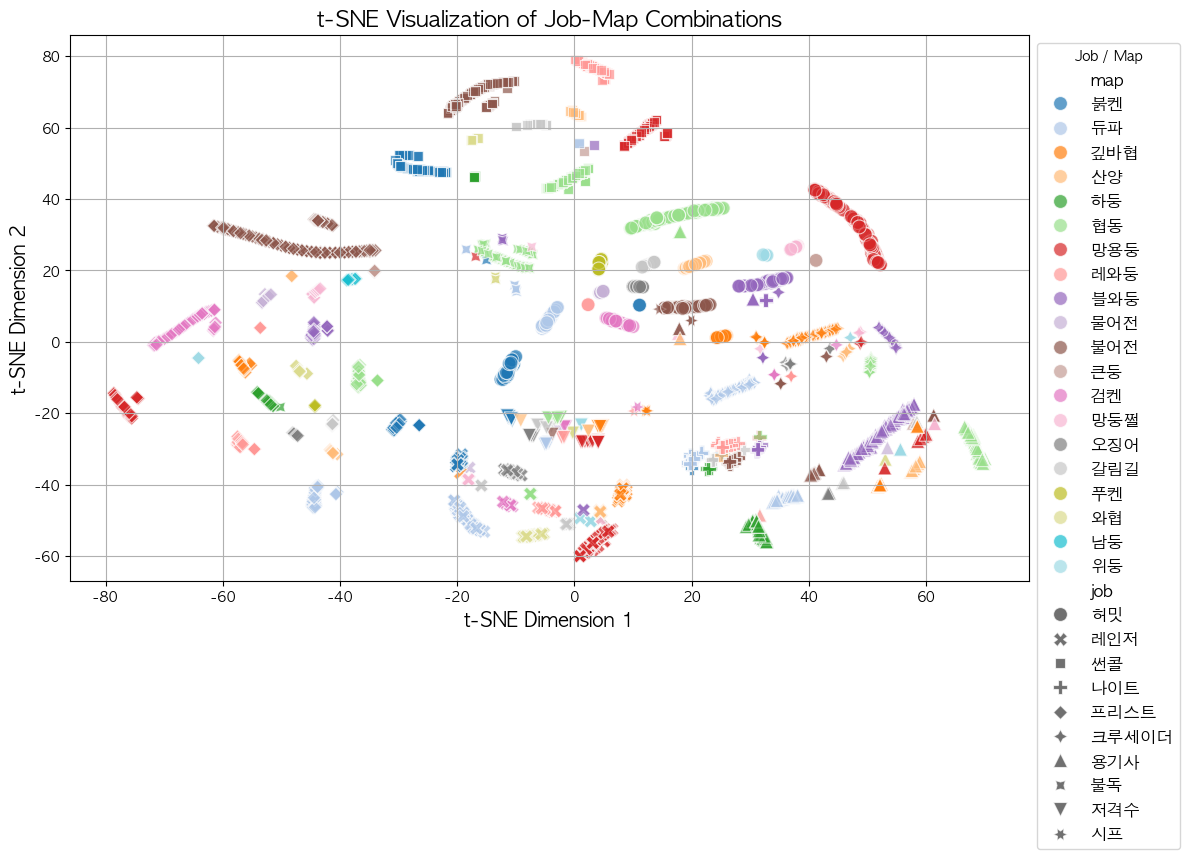

      party_id      time       level  job  spec  map        date  valid  \
1103        33   오후 5:44  145.000000  용기사   NaN  깊바협  2024-12-13   True   
1335       228   오후 4:38  122.516777   썬콜   NaN  망둥쩔  2024-12-12   True   
2374        25  오전 12:19  115.000000  용기사   NaN   검켄  2024-12-16   True   
3439       194   오후 1:53   92.000000   시프   NaN   붉켄  2024-12-17   True   

      valid_spec  spec_by_level  avg_spec_by_level  spec_filled  \
1103       False            NaN                NaN  2196.105984   
1335       False       6.211597           6.211597  2196.105984   
2374       False      35.369864          35.369864  3974.895052   
3439       False            NaN                NaN  2196.105984   

      spec_distance  avg_distance_per_job  tsne_dim1  tsne_dim2  \
1103            NaN                   NaN  28.459871   1.793239   
1335            NaN            797.788403 -12.410625  64.523689   
2374            NaN           4700.830136  39.946606 -40.618149   
3439            NaN 

In [77]:
%run modeling.ipynb
recommended_maps = recommend_map_knn(140, "용기사", level_range=5)
recommended_maps = recommend_map_svd(140, "용기사", level_range=5)
df_with_tsne = apply_tsne(df)  # Apply t-SNE
df_filtered, outliers = filter_outliers_by_tsne(df_with_tsne, top_percentile=99.9)
visualize_tsne(df_filtered)

In [70]:
#by Willkie